## Automated Surface Event Detection from Seismograms
Author: Akash Kharita
    
This notebook demonstrates how to use my machine learning model to detect surface events (snow avalanches/rockfalls/debris flows) through continuous seismograms from multiple station. We will take examples of verified events and see how my model/detector behaves around the event. 


Feel free to run this model on the starttimes and durations you would like!

## Importing dependencies


In [1]:
from continous_data_classification import event_detection
from continous_data_classification import plot_detection_results
from zenodo_get import zenodo_get
from obspy.clients.fdsn import Client
client = Client('IRIS')
import obspy
import pandas as pd
from joblib import dump, load
import os

## Downloading the model and scaler parameters


Now we are downloading the trained model and scaler parameters files stored remotely on a Zenodo repository. 
We are downloading three trained random forest models and corresponding scaler parameter files. 

The nomenclature of the model is as follows - P_before_after_F_lowcut_highcut_new sampling rate
So for example if the file is named as P_10_30_F_1_15_50, that means that the model is trained on the waveforms that start 10s before the first arrival and 30 



Description
This dataset contains three trained  random forest models named as following - 

- P_10_100_F_05_15_50.joblib - This is a model trained on 110s long waveforms (origin time - 10, origin time +100) in case of earthquakes and explosions and (first arrival pick -10, first arrival pick + 100) in case of surface events, the waveforms are tapered using 10% cosine taper, bandpass filtered between 0.5-15 Hz using Butterworth four corner filter, normalized and resampled to 50 Hz. 
- P_50_100_F_05_15_50.joblib 
- P_10_30_F_05_15_50.joblib. 


And also the standard scaler parameters for each features that will be used to normalize them. 

In [2]:
doi = '10.5281/zenodo.13328865'
files = zenodo_get([doi])

Title: Trained Random Forest Model and Scaler Parameters for (Phy+Man), 15 August, 2024
Keywords: 
Publication date: 2024-08-15
DOI: 10.5281/zenodo.13328865
Total size: 619.2 MB

Link: https://zenodo.org/record/13328865/files/best_rf_model_all_features_phy_man_P_50_100_F_05_15_50.joblib   size: 30.9 MB

Checksum is correct. (a668f2b4b2b1b763d67eaf49889b7b4f)

Link: https://zenodo.org/record/13328865/files/best_rf_model_all_features_phy_man_P_10_30_F_05_15_50.joblib   size: 191.0 MB

Checksum is correct. (7398572baf267d603e53e0203340cc8f)

Link: https://zenodo.org/record/13328865/files/scaler_params_phy_man_P_10_30_F_05_15_50.csv   size: 0.0 MB

Checksum is correct. (cb4201470bac8fc1a7c19a20775ef95c)

Link: https://zenodo.org/record/13328865/files/scaler_params_phy_man_P_10_100_F_05_15_50.csv   size: 0.0 MB

Checksum is correct. (5978efd4b65ea406248f2bbb5db66e2f)

Link: https://zenodo.org/record/13328865/files/best_rf_model_all_features_phy_man_P_10_100_F_05_15_50.joblib   size: 196.8 M

In [3]:
def infer_info(filename):
    highcut = highcut = int(filename.split('_')[5]) # higher limit of bandpass
    win = int(filename.split('_')[1]) + int(filename.split('_')[2])
    new_sr = new_sr = int(filename.split('_')[-1])
    
    return highcut, win, new_sr

![Mount Rainier Stations](../Extras/Cover_Image.png)


![Mount Rainier Glaciers](../Extras/Mt_Rainier_Glaciers.png)

## First We will try our surface event detector to detect a snow avalanche that occurred on Carbon Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/20011713 and we can also see a video of the event here - https://www.facebook.com/100003168843736/videos/2824127924369475/


- Event type: Snow Avalanche
- Start Date: 	2020-04-09 13:28:41
- End Date: 2020-04-09 13:29:54
- Location: Carbon Glacier


100%|██████████| 60/60 [00:00<00:00, 638726.50it/s]

100%|██████████| 60/60 [00:00<00:00, 702955.98it/s]

1 Trace(s) in Stream:
UW.STAR.01.EHZ | 2020-04-09T13:27:41.009000Z - 2020-04-09T13:37:40.999000Z | 100.0 Hz, 60000 samples



100%|██████████| 60/60 [00:00<00:00, 638726.50it/s]

100%|██████████| 60/60 [00:00<00:00, 830555.25it/s]

1 Trace(s) in Stream:
UW.RCS..EHZ | 2020-04-09T13:27:41.009997Z - 2020-04-09T13:37:40.989997Z | 100.0 Hz, 59999 samples



100%|██████████| 60/60 [00:00<00:00, 672882.99it/s]

100%|██████████| 60/60 [00:00<00:00, 833305.43it/s]

3 Trace(s) in Stream:
UW.RCM..HHZ | 2020-04-09T13:27:41.000000Z - 2020-04-09T13:33:05.550000Z | 100.0 Hz, 32456 samples
UW.RCM..HHZ | 2020-04-09T13:33:12.440000Z - 2020-04-09T13:33:15.870000Z | 100.0 Hz, 344 samples
UW.RCM..HHZ | 2020-04-09T13:33:17.600000Z - 2020-04-09T13:37:41.000000Z | 100.0 Hz, 26341 samples



100%|██████████| 60/60 [00:00<00:00, 586615.94it/s]

100%|██████████| 60/60 [00:00<00:00, 738000.70it/s]

1 Trace(s) in Stream:
CC.OBSR..BHZ | 2020-04-09T13:27:41.010000Z - 2020-04-09T13:37:40.990000Z | 50.0 Hz, 30000 samples



100%|██████████| 4/4 [00:19<00:00,  4.75s/it]


57


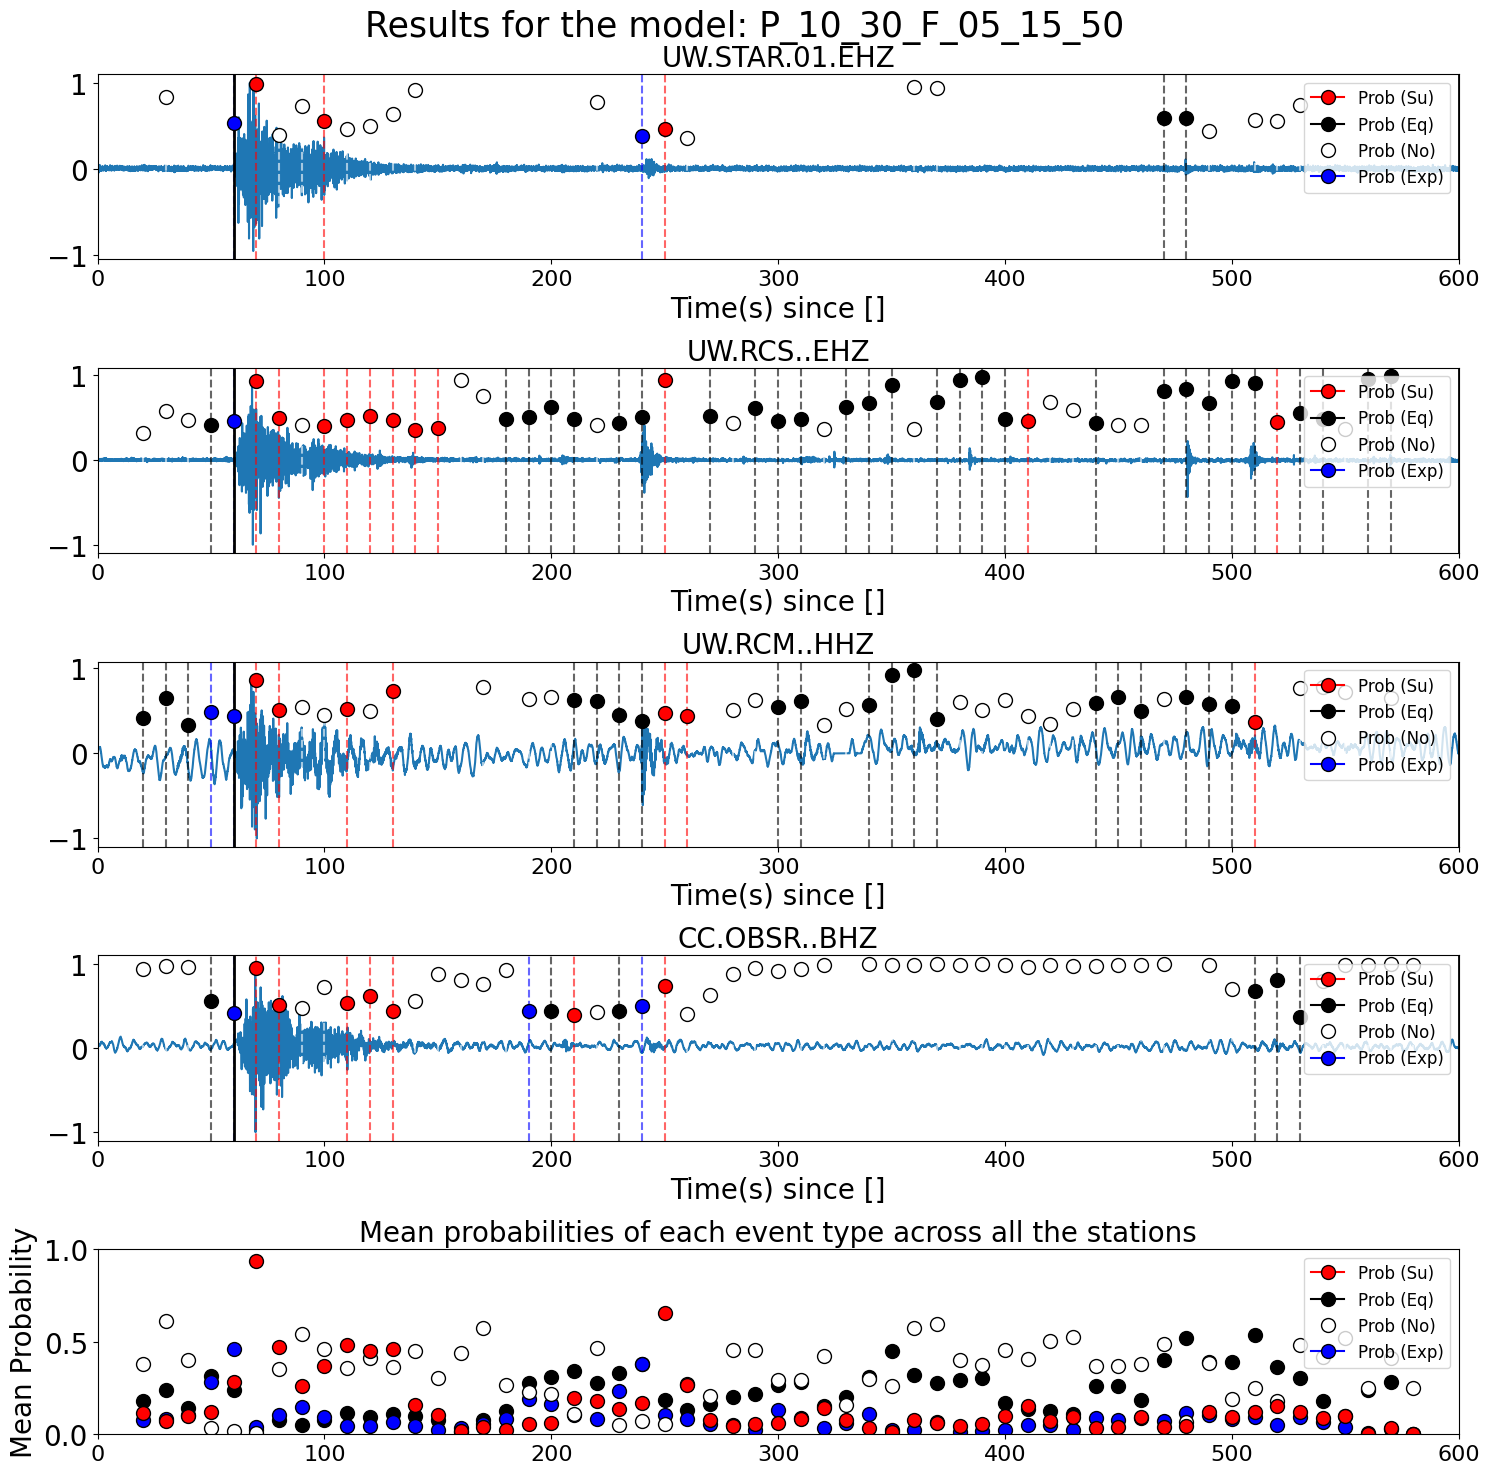

In [4]:
stride = 10
before = 60
# startttime of trace
starttime = obspy.UTCDateTime(2020, 4, 9, 13, 28, 41) - before

# duration
dur = 600

# stations ID
stations_id = ['UW.STAR', 'UW.RCS', 'UW.RCM', 'CC.OBSR']
location = '*'

top_20 = False

filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)

## Second We will try our surface event detector to detect a Icefall and Ice Avalanche that occurred on  Nisqually Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/14743775 and we can also see a video of the event here - https://www.youtube.com/watch?v=iDle-31t238


- Event type: Rockfall, Rock and Ice Avalanche
- Start Date: 	2011-06-25 23:04:05
- End Date: 2011-06-25 23:11:15
- Location: Nisqually Glacier


100%|██████████| 61/61 [00:00<00:00, 593625.39it/s]

100%|██████████| 61/61 [00:00<00:00, 825330.79it/s]

1 Trace(s) in Stream:
UW.RCS..EHZ | 2011-06-25T23:03:05.000000Z - 2011-06-25T23:13:05.000000Z | 100.0 Hz, 60001 samples



100%|██████████| 61/61 [00:00<00:00, 633298.38it/s]

100%|██████████| 61/61 [00:00<00:00, 855694.13it/s]

1 Trace(s) in Stream:
UW.RCM..EHZ | 2011-06-25T23:03:05.000000Z - 2011-06-25T23:13:05.000000Z | 100.0 Hz, 60001 samples



 50%|█████     | 3/6 [00:11<00:10,  3.34s/it]

0 Trace(s) in Stream:



 67%|██████▋   | 4/6 [00:12<00:04,  2.31s/it]

0 Trace(s) in Stream:




100%|██████████| 61/61 [00:00<00:00, 646092.28it/s]

100%|██████████| 61/61 [00:00<00:00, 855694.13it/s]

1 Trace(s) in Stream:
CC.PANH..BHZ | 2011-06-25T23:03:05.000000Z - 2011-06-25T23:13:05.000000Z | 50.0 Hz, 30001 samples



100%|██████████| 61/61 [00:00<00:00, 644464.85it/s]

100%|██████████| 61/61 [00:00<00:00, 830690.08it/s]

1 Trace(s) in Stream:
CC.OBSR..BHZ | 2011-06-25T23:03:05.000000Z - 2011-06-25T23:13:05.000000Z | 50.0 Hz, 30001 samples



100%|██████████| 6/6 [00:23<00:00,  3.83s/it]


57


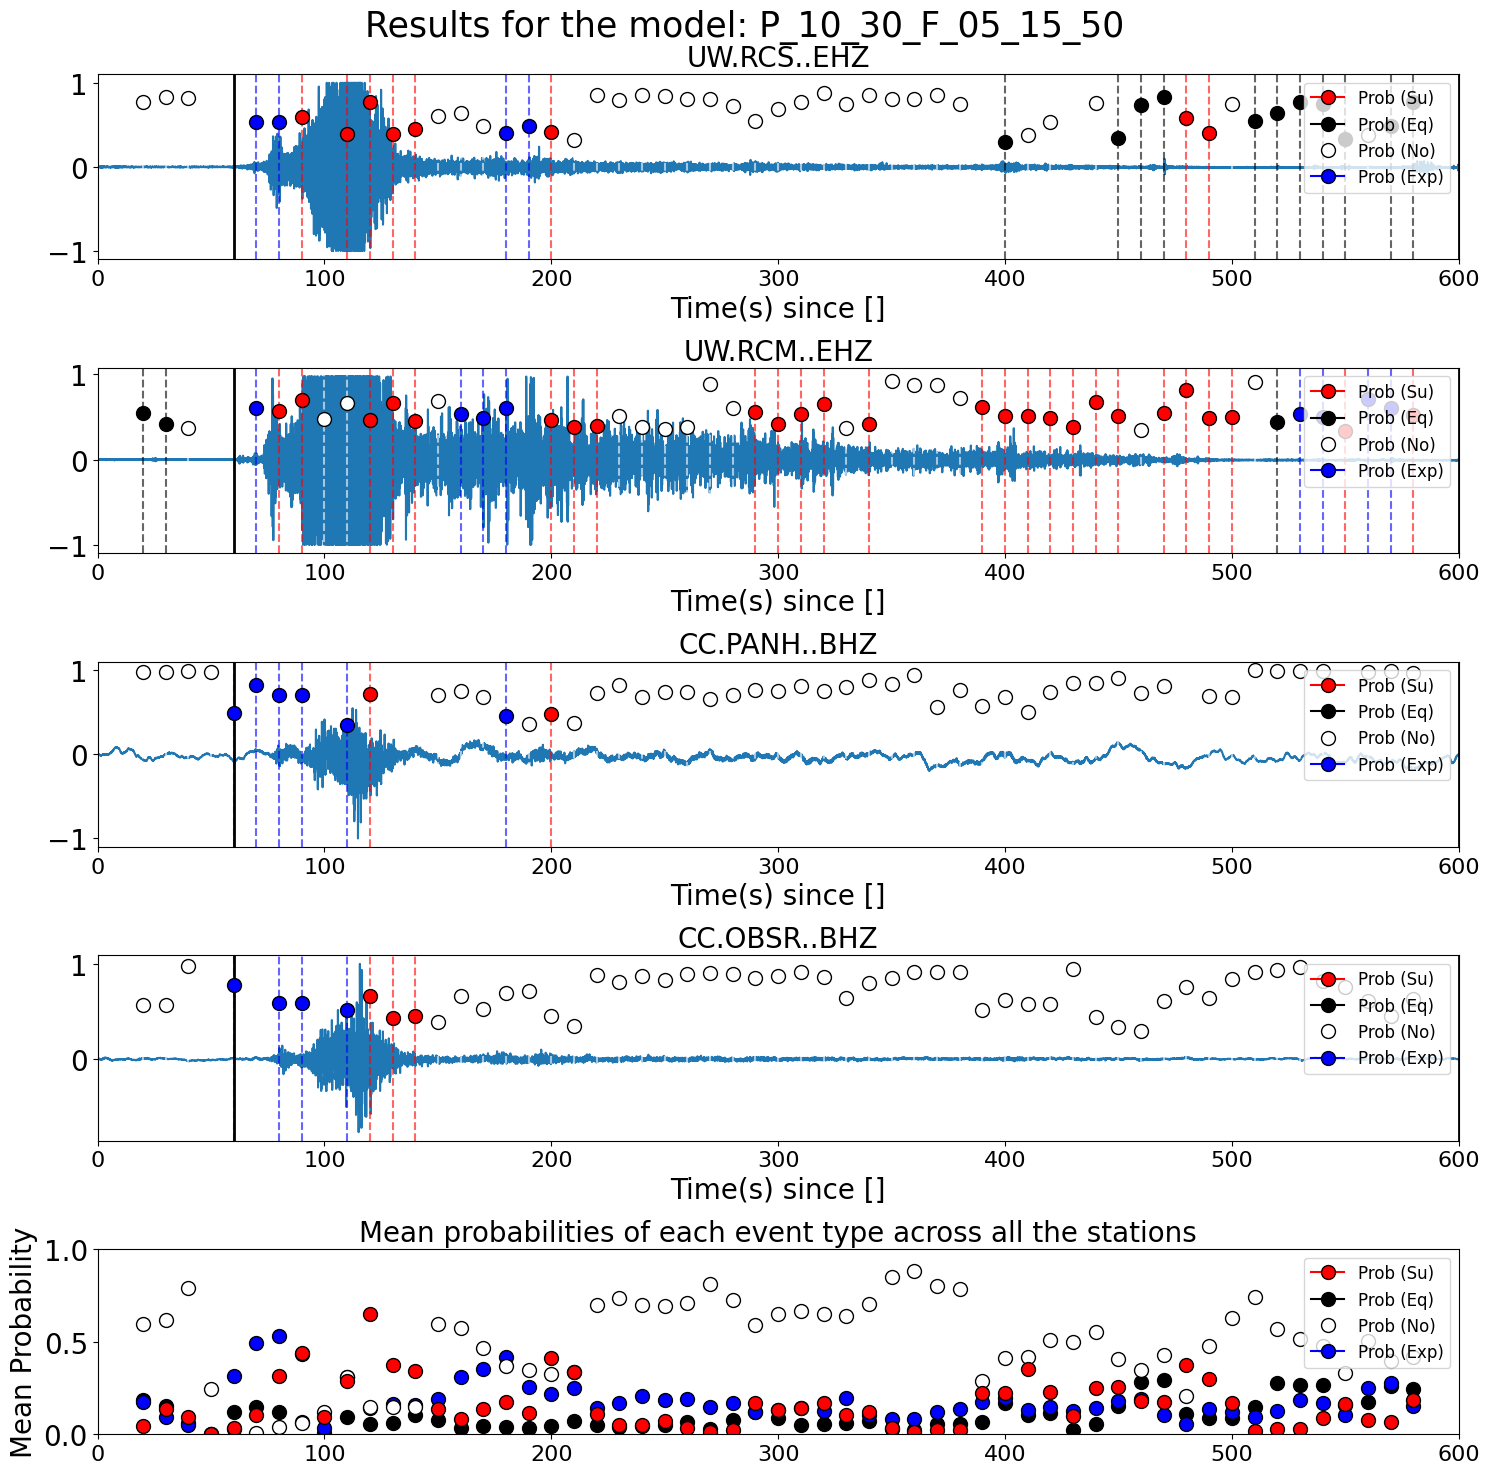

In [5]:
# startttime of trace
starttime = obspy.UTCDateTime(2011, 6, 25, 23, 4, 5) - 60

# duration
dur = 600

# stations ID
stations_id = [ 'UW.RCS', 'UW.RCM', 'CC.PARA', 'CC.COPP', 'CC.PANH', 'CC.OBSR']
location = '*'




filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)

## Third We will try our surface event detector to detect a Debris Flow that occurred on  Nisqually Glacier, Mount Rainier. 

This event is present in IRIS ESEC - https://ds.iris.edu/spud/esec/20008839 and we can also see more info of the event here - 


- Event type: Debris Flow
- Start Date: 	2019-09-27 00:43:20
- End Date: 	2019-09-27 01:29:22
- Location: Mount Rainier


100%|██████████| 361/361 [00:00<00:00, 988344.48it/s]

100%|██████████| 361/361 [00:00<00:00, 1325870.18it/s]

1 Trace(s) in Stream:
UW.LON..HHZ | 2019-09-27T00:42:20.000000Z - 2019-09-27T01:42:20.000000Z | 100.0 Hz, 360001 samples



100%|██████████| 360/360 [00:00<00:00, 926349.35it/s]

100%|██████████| 360/360 [00:00<00:00, 1205067.39it/s]

2 Trace(s) in Stream:
UW.RER..EHZ | 2019-09-27T00:42:20.000000Z - 2019-09-27T00:59:24.390000Z | 100.0 Hz, 102440 samples
UW.RER..EHZ | 2019-09-27T00:59:25.400000Z - 2019-09-27T01:42:20.000000Z | 100.0 Hz, 257461 samples



100%|██████████| 360/360 [00:00<00:00, 955664.20it/s]

100%|██████████| 360/360 [00:00<00:00, 1292764.93it/s]

1 Trace(s) in Stream:
UW.LO2..EHZ | 2019-09-27T00:42:20.000009Z - 2019-09-27T01:42:19.980009Z | 100.0 Hz, 359999 samples



100%|██████████| 360/360 [00:00<00:00, 943128.94it/s]

100%|██████████| 360/360 [00:00<00:00, 1286157.96it/s]

1 Trace(s) in Stream:
UW.RCS..EHZ | 2019-09-27T00:42:20.000009Z - 2019-09-27T01:42:19.980009Z | 100.0 Hz, 359999 samples



100%|██████████| 361/361 [00:00<00:00, 930063.72it/s]

100%|██████████| 361/361 [00:00<00:00, 1242119.56it/s]

1 Trace(s) in Stream:
UW.RCM..HHZ | 2019-09-27T00:42:20.000000Z - 2019-09-27T01:42:20.000000Z | 100.0 Hz, 360001 samples



100%|██████████| 720/720 [00:00<00:00, 1035985.89it/s]

100%|██████████| 720/720 [00:00<00:00, 1290555.08it/s]

2 Trace(s) in Stream:
UW.STAR..EHZ   | 2019-09-27T00:42:20.000009Z - 2019-09-27T01:42:19.980009Z | 100.0 Hz, 359999 samples
UW.STAR.01.EHZ | 2019-09-27T00:42:20.000000Z - 2019-09-27T01:42:20.000000Z | 100.0 Hz, 360001 samples



 78%|███████▊  | 7/9 [03:27<00:53, 26.65s/it]

0 Trace(s) in Stream:



 89%|████████▉ | 8/9 [03:28<00:18, 18.40s/it]

0 Trace(s) in Stream:



100%|██████████| 9/9 [03:28<00:00, 23.20s/it]

0 Trace(s) in Stream:



717


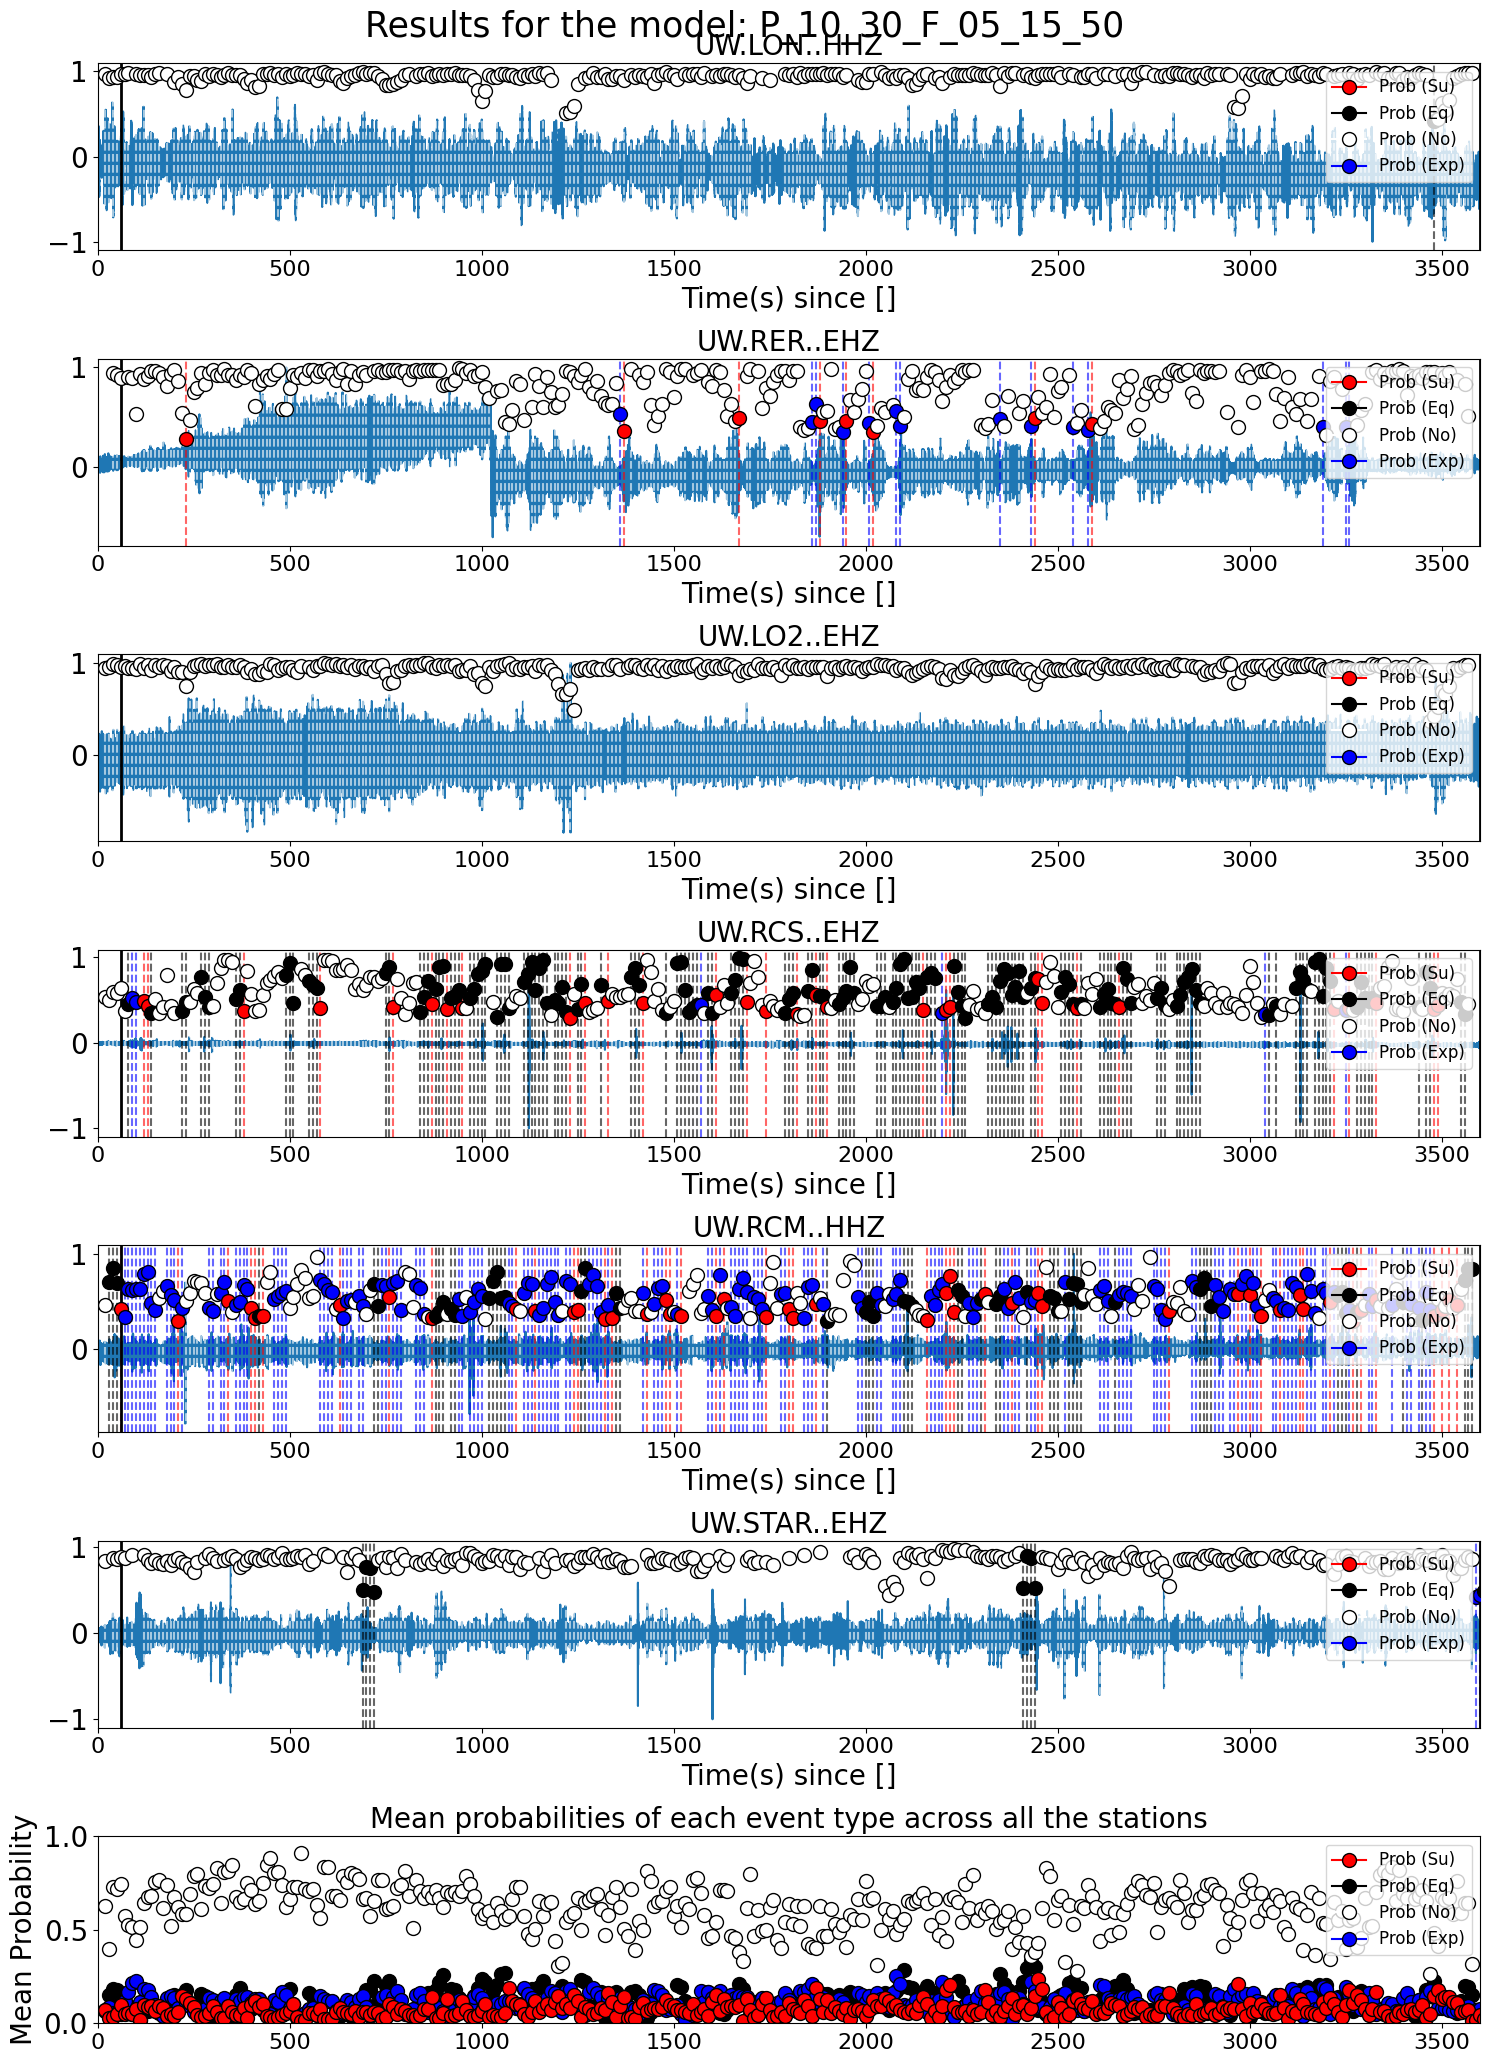

In [6]:
# startttime of trace
starttime = obspy.UTCDateTime(2019, 9, 27, 0, 43, 20) - 60

# duration
dur = 60*60

# stations ID
stations_id = [ 'UW.LON', 'UW.RER','UW.LO2', 'UW.RCS', 'UW.RCM', 'UW.STAR', 'CC.PARA', 'CC.MIRR', 'CC.TABR']
location = '*'




filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)

## Another confirmed rockfall, this rockfall fooled the PNSN automated event detection and was labeled as Earthquake initially but further analysis revealed its actually a rockfall

More information about this event can be seen here - 
https://pnsn.org/blog/2015/08/21/summer-rockfall-time-yet-again

100%|██████████| 35/35 [00:00<00:00, 472027.78it/s]

100%|██████████| 35/35 [00:00<00:00, 646698.85it/s]

2 Trace(s) in Stream:
UW.RER..EHZ | 2015-08-19T18:47:53.000000Z - 2015-08-19T18:51:24.590000Z | 100.0 Hz, 21160 samples
UW.RER..EHZ | 2015-08-19T18:51:42.600000Z - 2015-08-19T18:53:53.000000Z | 100.0 Hz, 13041 samples



 29%|██▊       | 2/7 [00:03<00:08,  1.77s/it]

0 Trace(s) in Stream:




100%|██████████| 36/36 [00:00<00:00, 545108.10it/s]

100%|██████████| 36/36 [00:00<00:00, 653657.77it/s]

1 Trace(s) in Stream:
UW.STAR..EHZ | 2015-08-19T18:47:53.000406Z - 2015-08-19T18:53:52.990406Z | 100.0 Hz, 36000 samples



100%|██████████| 36/36 [00:00<00:00, 524288.00it/s]

100%|██████████| 36/36 [00:00<00:00, 653657.77it/s]

1 Trace(s) in Stream:
UW.RCS..EHZ | 2015-08-19T18:47:53.000410Z - 2015-08-19T18:53:52.990410Z | 100.0 Hz, 36000 samples



100%|██████████| 36/36 [00:00<00:00, 522473.85it/s]

100%|██████████| 36/36 [00:00<00:00, 645277.54it/s]

1 Trace(s) in Stream:
UW.FMW..EHZ | 2015-08-19T18:47:53.000410Z - 2015-08-19T18:53:52.990410Z | 100.0 Hz, 36000 samples



100%|██████████| 36/36 [00:00<00:00, 517105.97it/s]

100%|██████████| 36/36 [00:00<00:00, 639809.08it/s]

1 Trace(s) in Stream:
UW.WPW..EHZ | 2015-08-19T18:47:53.000408Z - 2015-08-19T18:53:52.990408Z | 100.0 Hz, 36000 samples



100%|██████████| 37/37 [00:00<00:00, 478979.16it/s]

100%|██████████| 37/37 [00:00<00:00, 649327.40it/s]

1 Trace(s) in Stream:
CC.PANH..BHZ | 2015-08-19T18:47:53.000000Z - 2015-08-19T18:53:53.000000Z | 50.0 Hz, 18001 samples



100%|██████████| 7/7 [00:20<00:00,  2.93s/it]


33


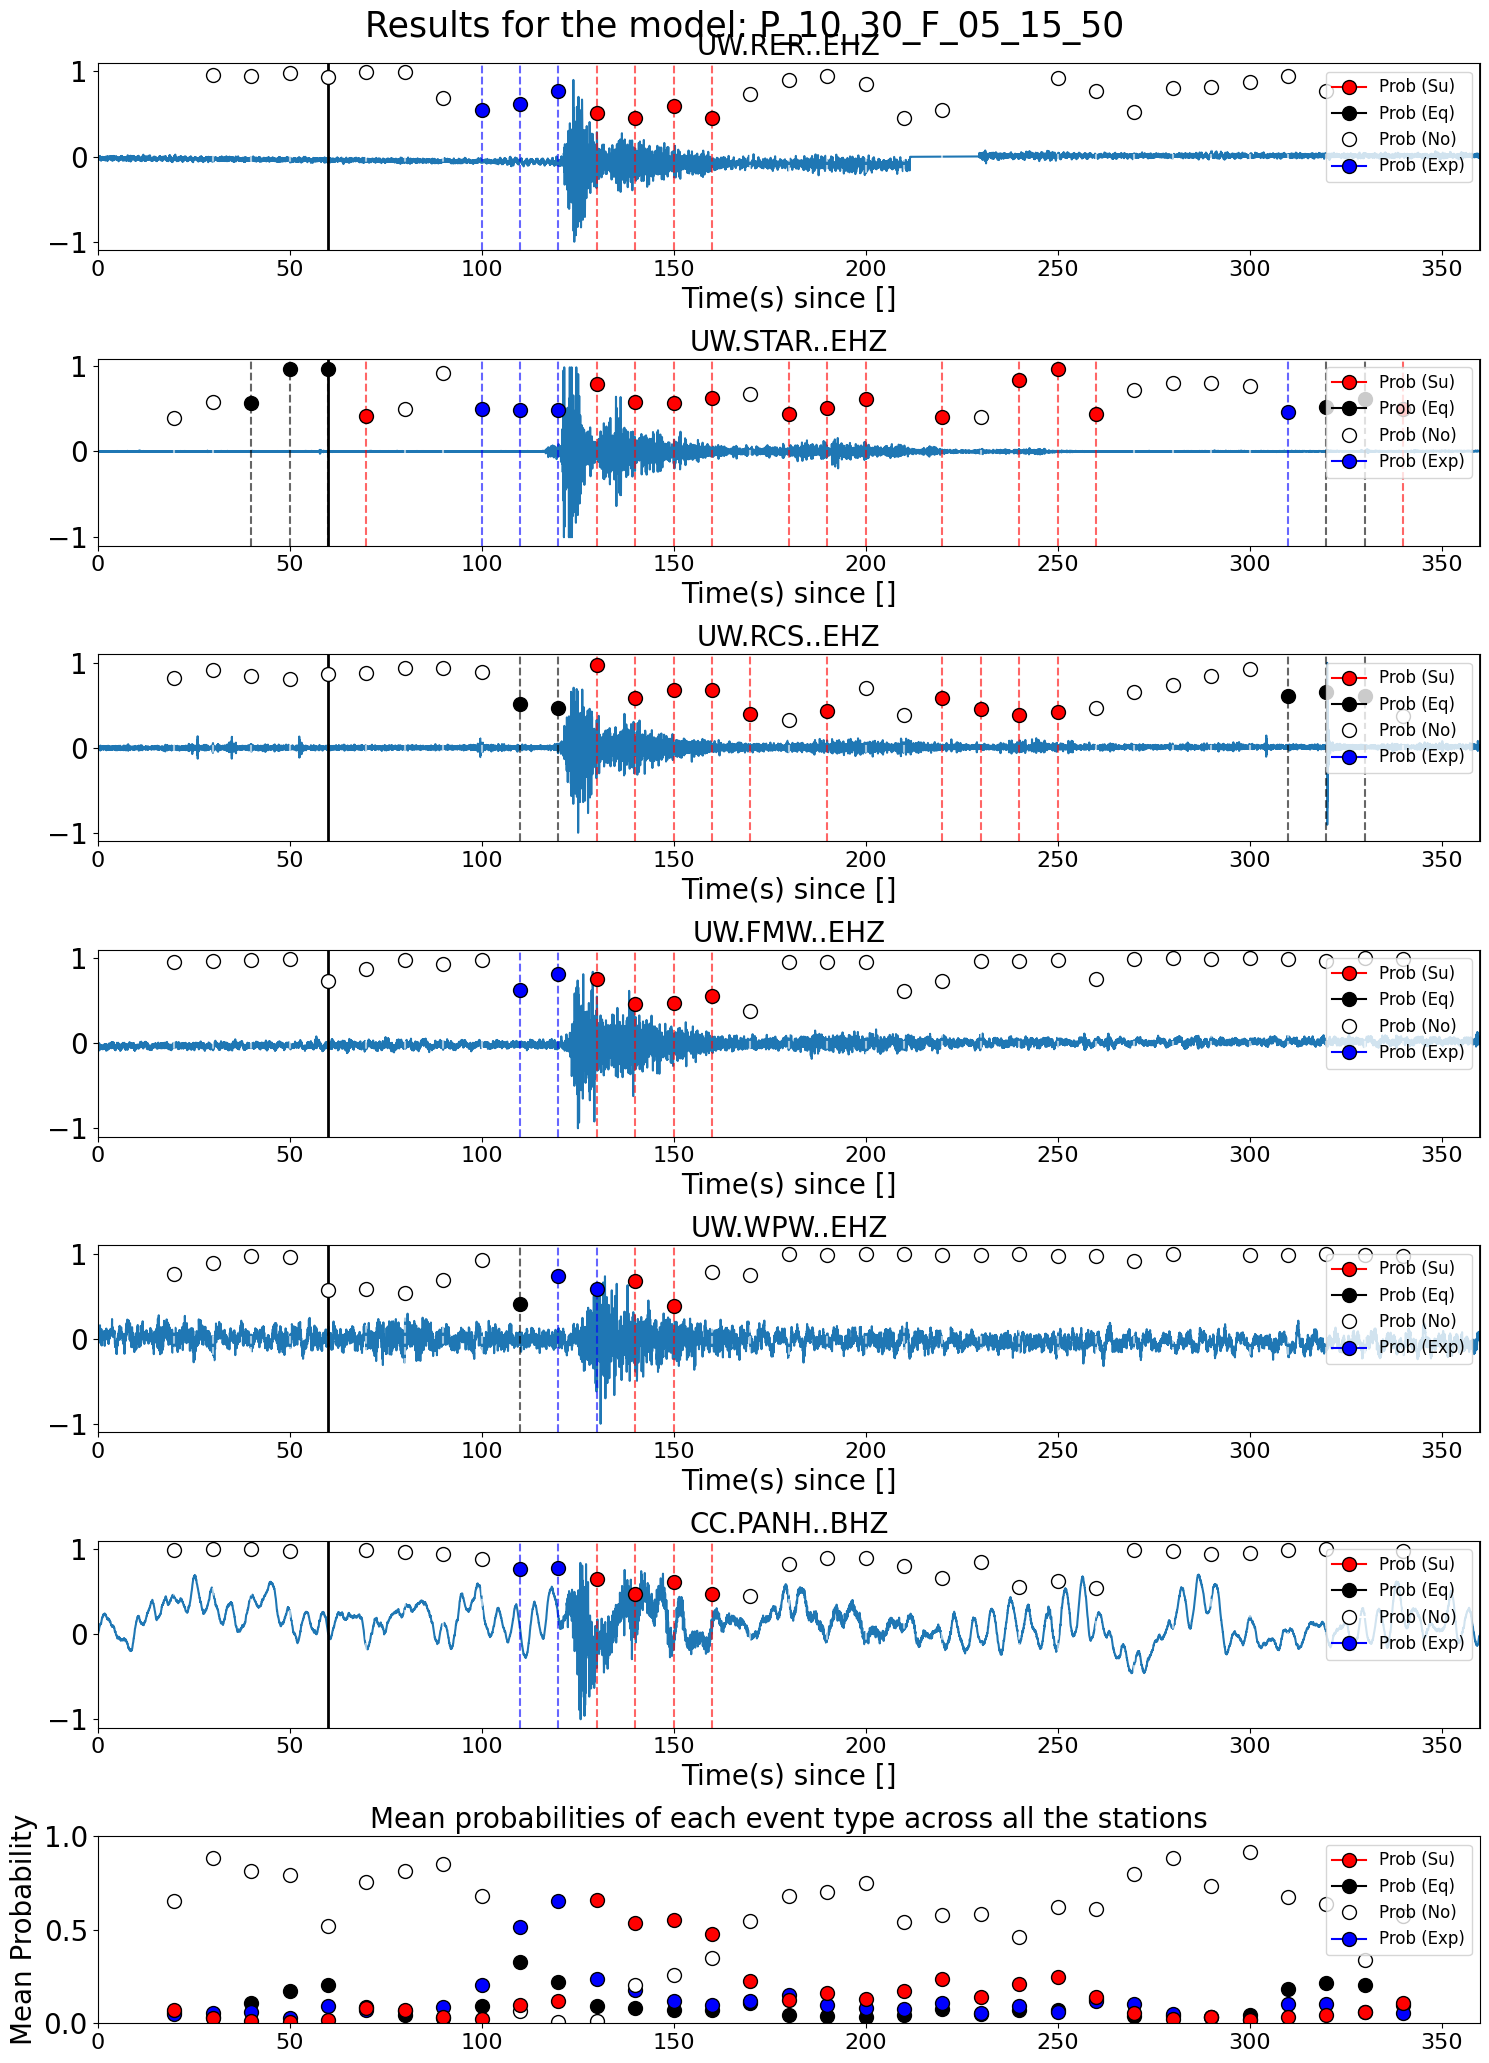

In [7]:
# startttime of trace
starttime = obspy.UTCDateTime(2015, 8, 19, 18, 49, 53) - 120

# duration
dur = 360

# stations ID
stations_id = [ 'UW.RER', 'UW.RCM', 'UW.STAR', 'UW.RCS', 'UW.FMW', 'UW.WPW', 'CC.PANH']


location = '*'




filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)



## Testing the same event with 110s model

100%|██████████| 35/35 [00:00<00:00, 551882.11it/s]

100%|██████████| 35/35 [00:00<00:00, 664256.29it/s]

2 Trace(s) in Stream:
UW.RER..EHZ | 2015-08-19T18:47:53.000000Z - 2015-08-19T18:51:24.590000Z | 100.0 Hz, 21160 samples
UW.RER..EHZ | 2015-08-19T18:51:42.600000Z - 2015-08-19T18:53:53.000000Z | 100.0 Hz, 13041 samples



 29%|██▊       | 2/7 [00:03<00:07,  1.60s/it]

0 Trace(s) in Stream:




100%|██████████| 36/36 [00:00<00:00, 553095.03it/s]

100%|██████████| 36/36 [00:00<00:00, 662258.53it/s]

1 Trace(s) in Stream:
UW.STAR..EHZ | 2015-08-19T18:47:53.000406Z - 2015-08-19T18:53:52.990406Z | 100.0 Hz, 36000 samples



100%|██████████| 36/36 [00:00<00:00, 559240.53it/s]

100%|██████████| 36/36 [00:00<00:00, 677107.37it/s]

1 Trace(s) in Stream:
UW.RCS..EHZ | 2015-08-19T18:47:53.000410Z - 2015-08-19T18:53:52.990410Z | 100.0 Hz, 36000 samples



100%|██████████| 36/36 [00:00<00:00, 520672.22it/s]

100%|██████████| 36/36 [00:00<00:00, 680157.41it/s]

1 Trace(s) in Stream:
UW.FMW..EHZ | 2015-08-19T18:47:53.000410Z - 2015-08-19T18:53:52.990410Z | 100.0 Hz, 36000 samples



100%|██████████| 36/36 [00:00<00:00, 555128.47it/s]

100%|██████████| 36/36 [00:00<00:00, 668119.22it/s]

1 Trace(s) in Stream:
UW.WPW..EHZ | 2015-08-19T18:47:53.000408Z - 2015-08-19T18:53:52.990408Z | 100.0 Hz, 36000 samples



100%|██████████| 37/37 [00:00<00:00, 570548.71it/s]

100%|██████████| 37/37 [00:00<00:00, 613396.24it/s]

1 Trace(s) in Stream:
CC.PANH..BHZ | 2015-08-19T18:47:53.000000Z - 2015-08-19T18:53:53.000000Z | 50.0 Hz, 18001 samples



100%|██████████| 7/7 [00:17<00:00,  2.55s/it]


26


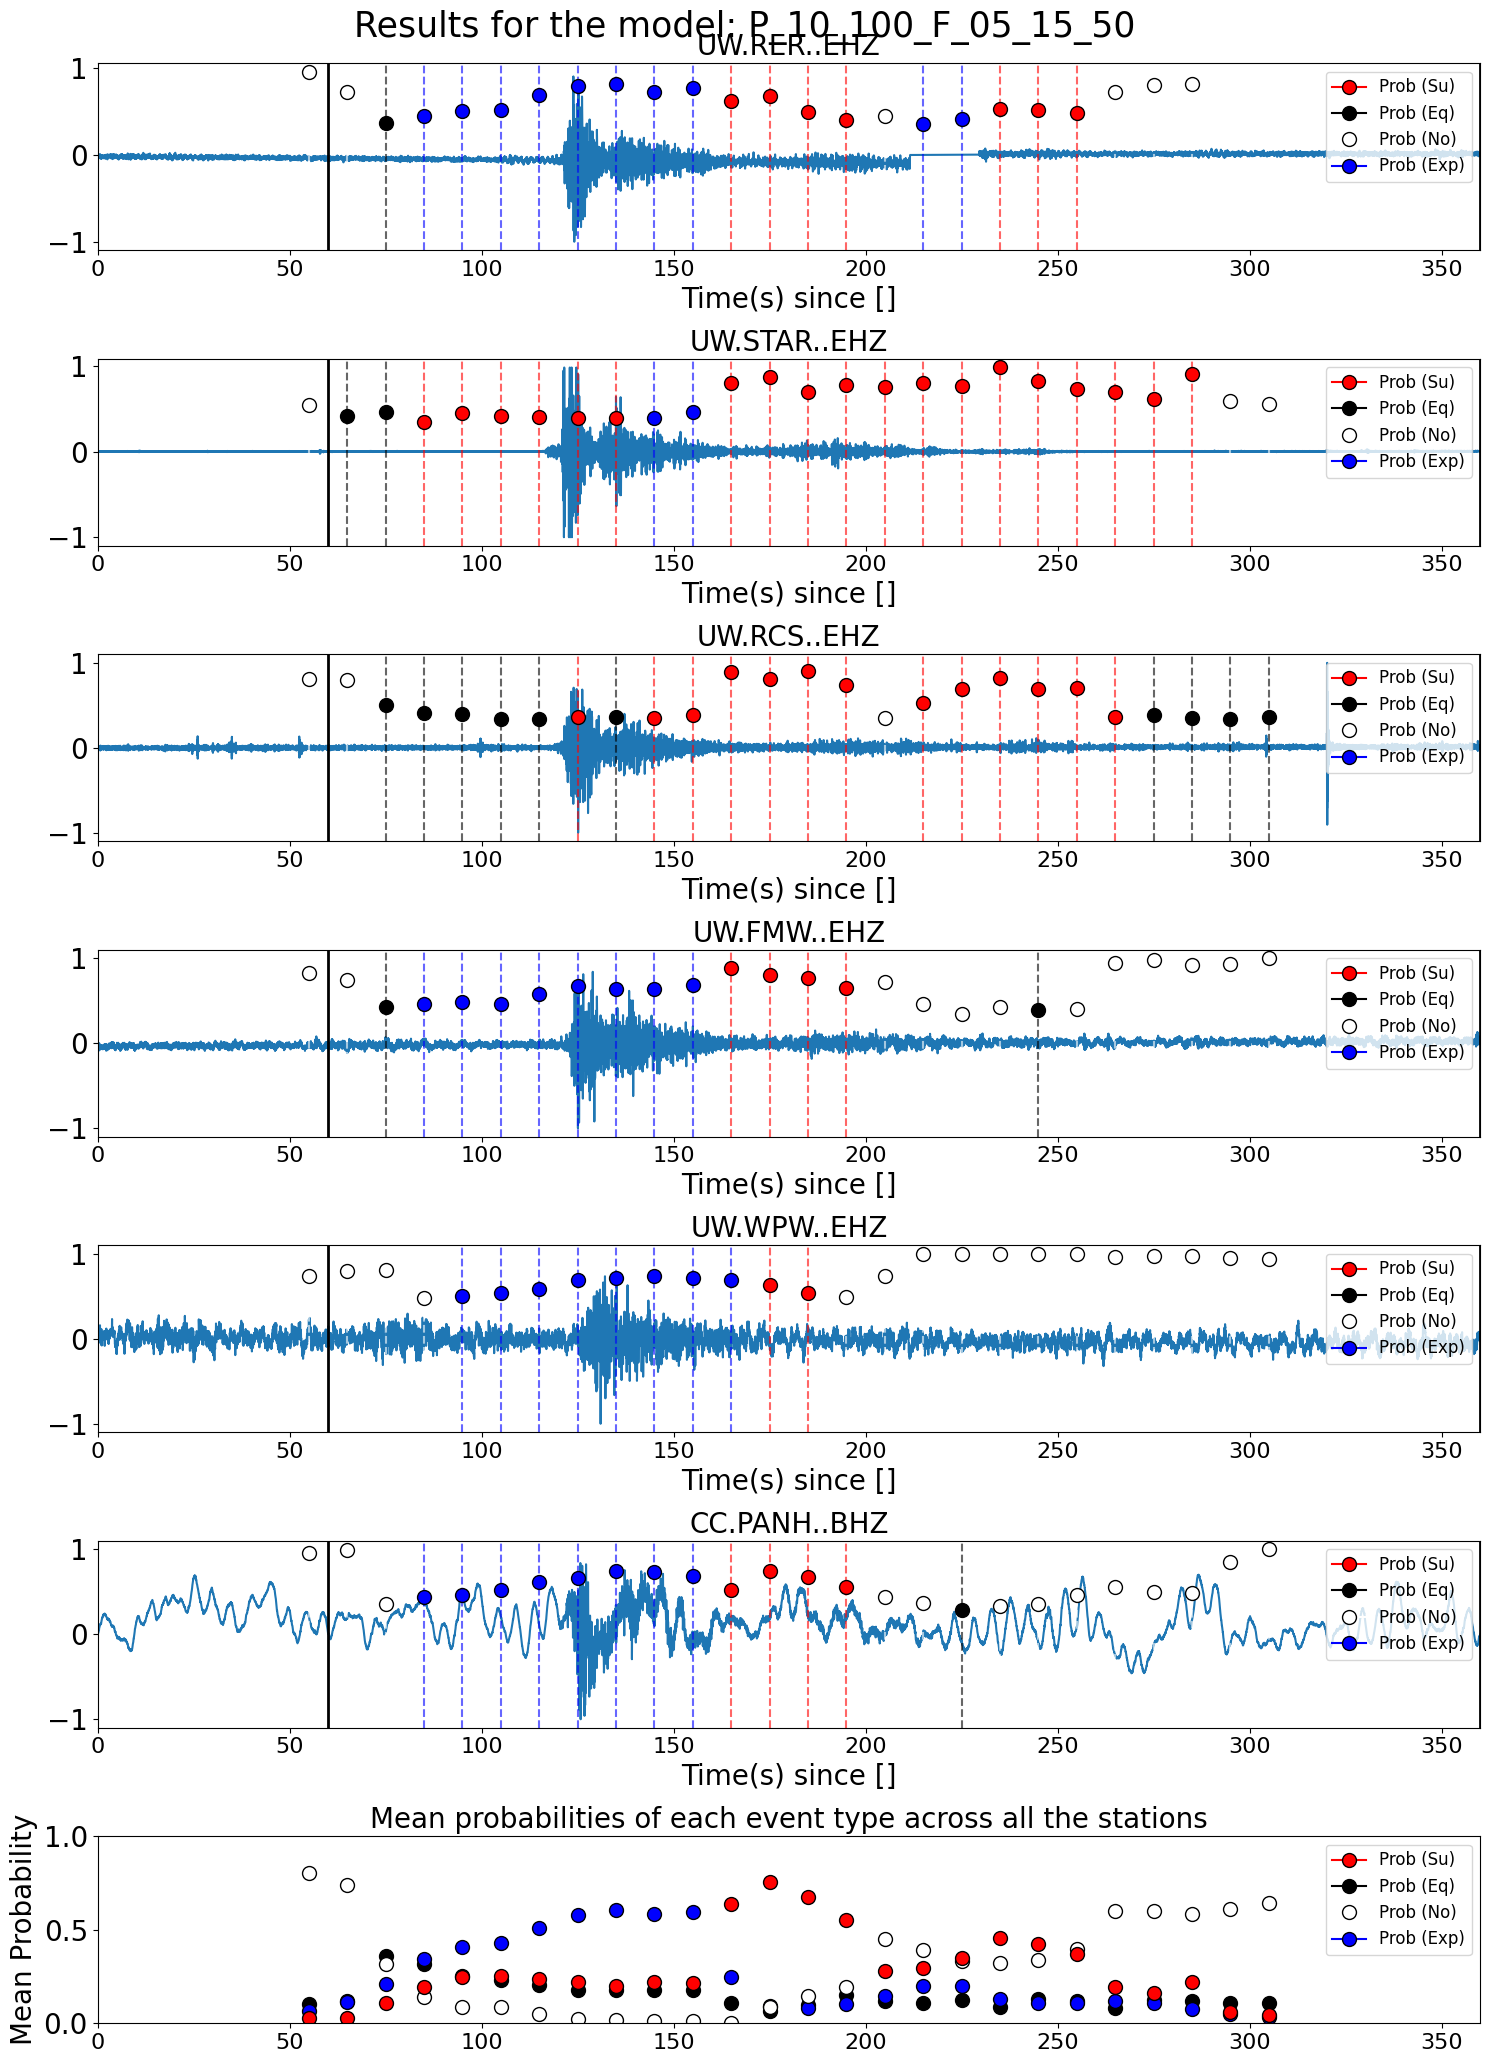

In [8]:
# startttime of trace
starttime = obspy.UTCDateTime(2015, 8, 19, 18, 49, 53) - 120

# duration
dur = 360

# stations ID
stations_id = [ 'UW.RER', 'UW.RCM', 'UW.STAR', 'UW.RCS', 'UW.FMW', 'UW.WPW', 'CC.PANH']


location = '*'




filename = 'P_10_100_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)



## Testing the model on the events in different region than the model was trained on

- Here we are going to test our model on two large avalanches described very well in this paper - https://esurf.copernicus.org/articles/9/271/2021/ 

These avalanches occur on Iliamna volcano, one in 2016 and other one in 2019

100%|██████████| 36/36 [00:00<00:00, 513588.24it/s]

100%|██████████| 36/36 [00:00<00:00, 629145.60it/s]

1 Trace(s) in Stream:
AV.ILSW..BHZ | 2016-05-22T07:56:50.008000Z - 2016-05-22T08:02:49.988000Z | 50.0 Hz, 18000 samples



100%|██████████| 36/36 [00:00<00:00, 498333.15it/s]

100%|██████████| 36/36 [00:00<00:00, 639809.08it/s]

1 Trace(s) in Stream:
TA.O20K..BHZ | 2016-05-22T07:56:50.024998Z - 2016-05-22T08:02:49.999998Z | 40.0 Hz, 14400 samples



100%|██████████| 37/37 [00:00<00:00, 522522.72it/s]

100%|██████████| 37/37 [00:00<00:00, 613396.24it/s]

1 Trace(s) in Stream:
AV.OPT..EHZ | 2016-05-22T07:56:50.000000Z - 2016-05-22T08:02:50.000000Z | 100.0 Hz, 36001 samples



100%|██████████| 36/36 [00:00<00:00, 517105.97it/s]

100%|██████████| 36/36 [00:00<00:00, 608850.58it/s]

1 Trace(s) in Stream:
AK.HOM..BHZ | 2016-05-22T07:56:50.008400Z - 2016-05-22T08:02:49.988400Z | 50.0 Hz, 18000 samples



100%|██████████| 4/4 [00:13<00:00,  3.34s/it]


33


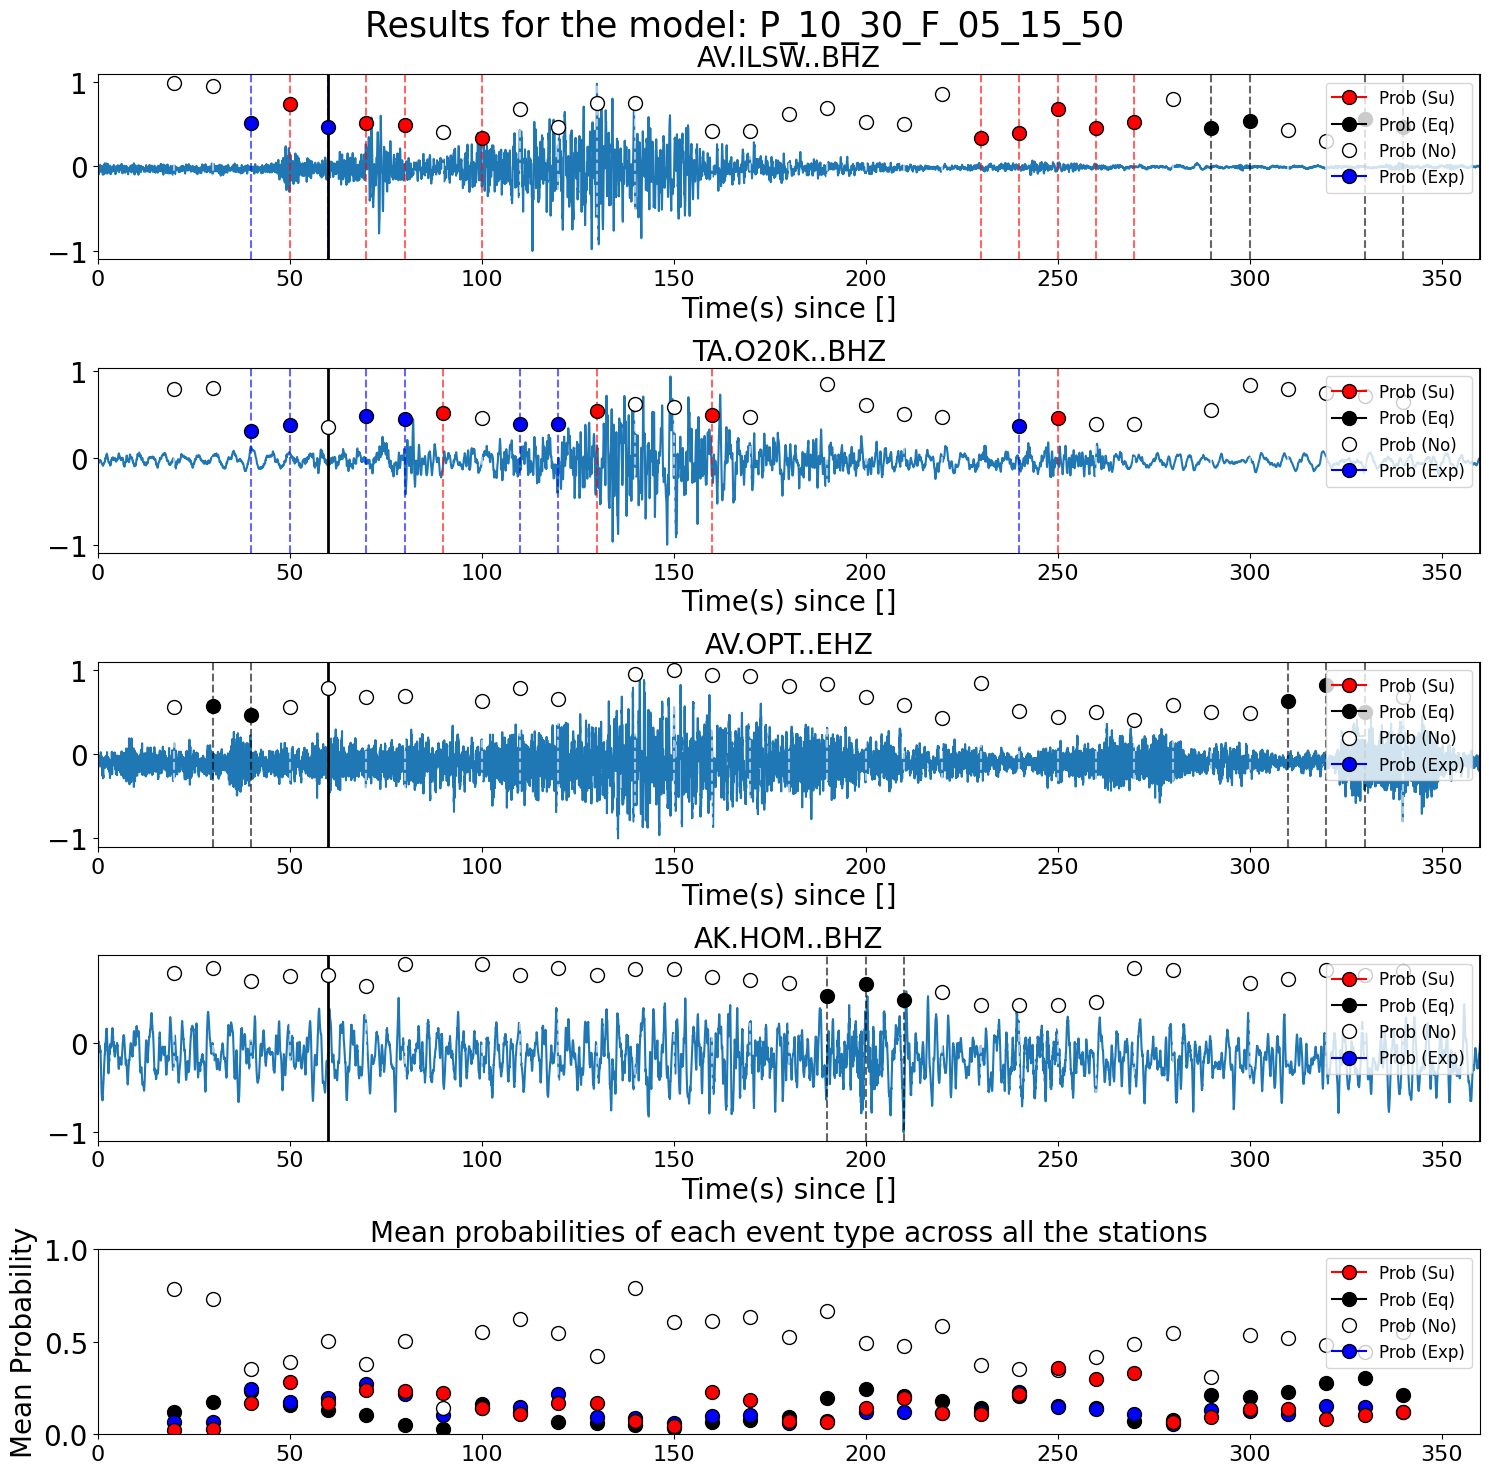

In [9]:
# startttime of trace (UTCDateTime)
starttime = obspy.UTCDateTime(2016, 5, 22, 7, 56, 0) + 50

# duration
dur = 360

# stations ID
stations_id = [ 'AV.ILSW', 'TA.O20K', 'AV.OPT', 'AK.HOM']
location = '*'




filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)

## Testing the model on 2019 event

100%|██████████| 48/48 [00:00<00:00, 565524.13it/s]

100%|██████████| 48/48 [00:00<00:00, 701486.38it/s]

1 Trace(s) in Stream:
AV.ILSW..BHZ | 2019-06-21T00:00:01.008000Z - 2019-06-21T00:08:00.988000Z | 50.0 Hz, 24000 samples



100%|██████████| 49/49 [00:00<00:00, 567737.28it/s]

100%|██████████| 49/49 [00:00<00:00, 726222.25it/s]

1 Trace(s) in Stream:
TA.O20K..BHZ | 2019-06-21T00:00:01.000000Z - 2019-06-21T00:08:01.000000Z | 40.0 Hz, 19201 samples



100%|██████████| 49/49 [00:00<00:00, 630432.20it/s]

100%|██████████| 49/49 [00:00<00:00, 682793.67it/s]

1 Trace(s) in Stream:
AV.OPT..EHZ | 2019-06-21T00:00:01.000000Z - 2019-06-21T00:08:01.000000Z | 100.0 Hz, 48001 samples



100%|██████████| 48/48 [00:00<00:00, 606405.40it/s]

100%|██████████| 48/48 [00:00<00:00, 666644.34it/s]

1 Trace(s) in Stream:
AK.HOM..BHZ | 2019-06-21T00:00:01.008400Z - 2019-06-21T00:08:00.988400Z | 50.0 Hz, 24000 samples



100%|██████████| 4/4 [00:17<00:00,  4.42s/it]


45


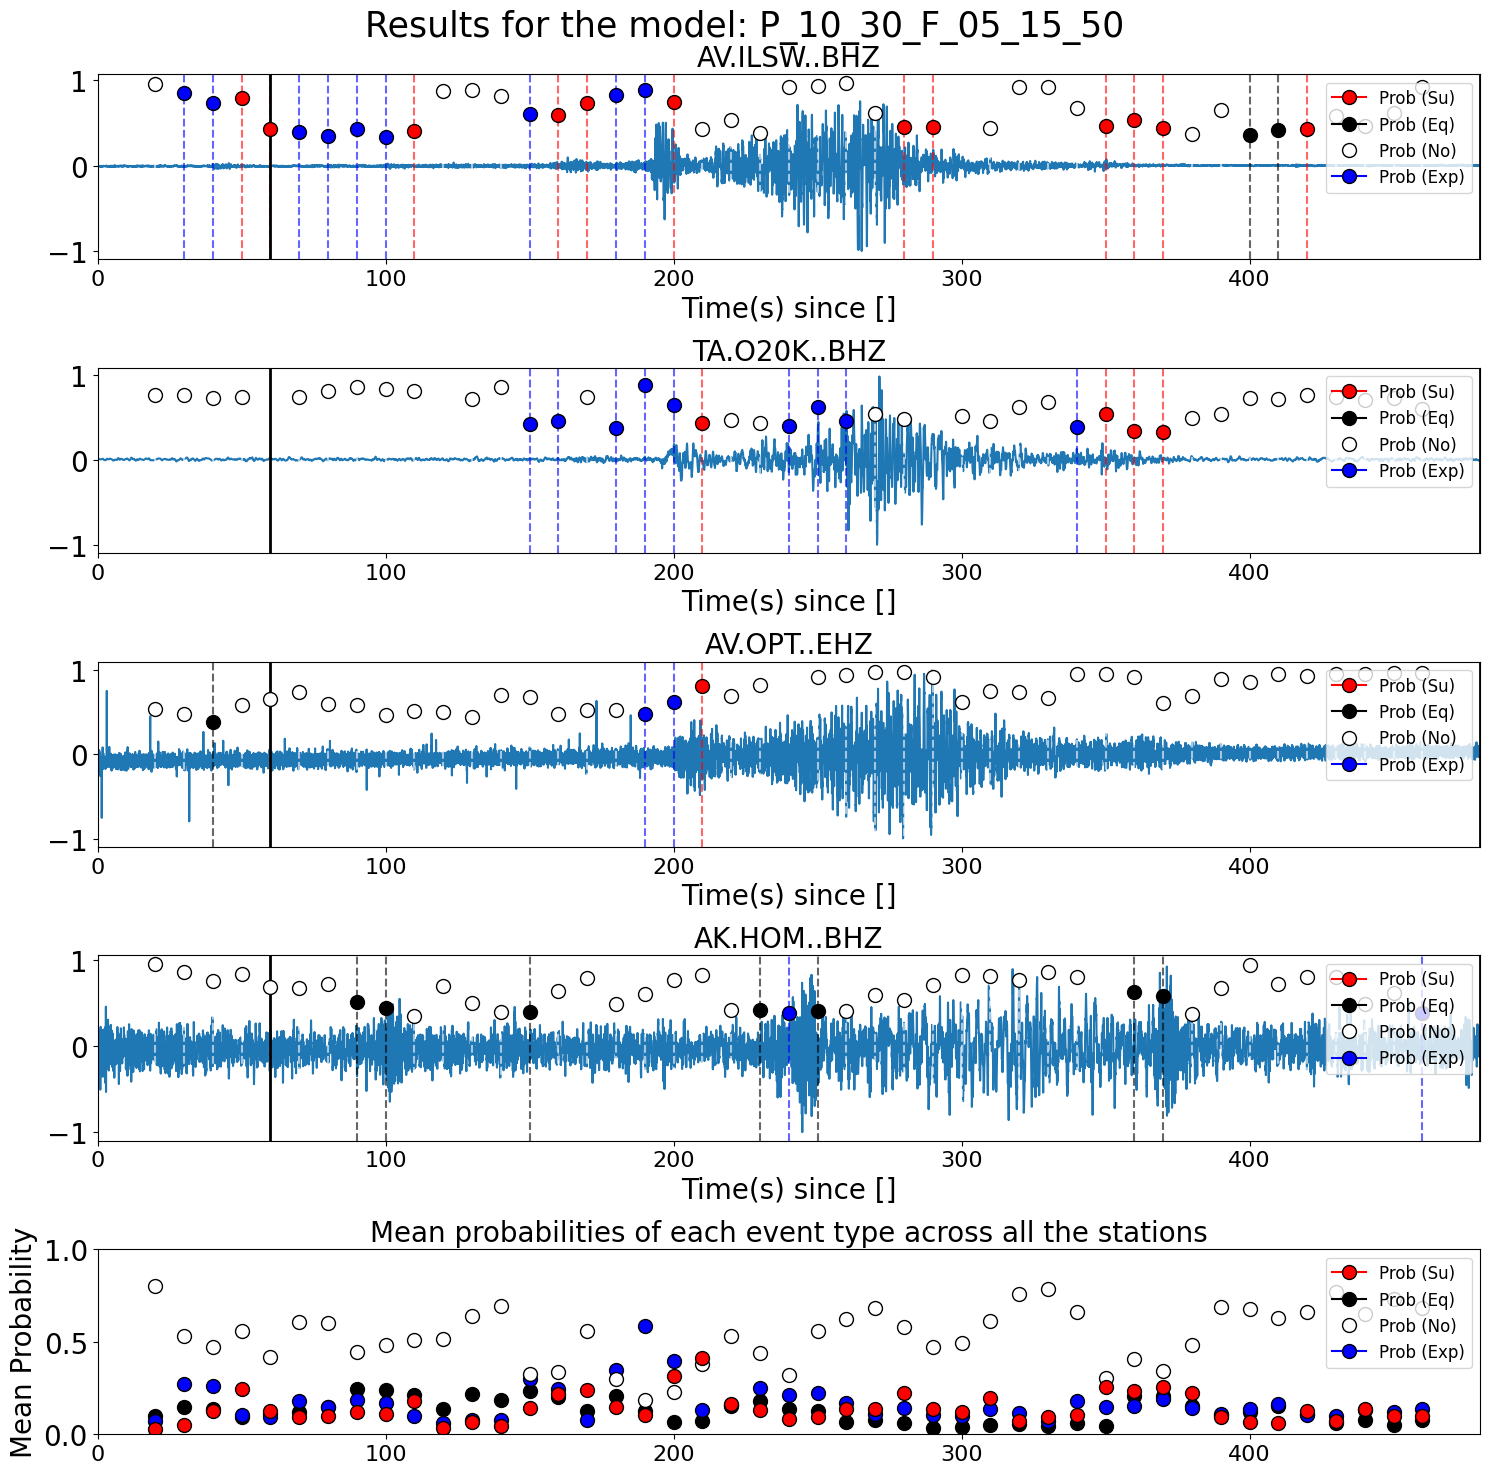

In [10]:
# startttime of trace (UTCDateTime)
starttime = obspy.UTCDateTime(2019, 6, 21, 0, 0, 1) - 0

# duration
dur = 480

# stations ID
stations_id = [ 'AV.ILSW', 'TA.O20K', 'AV.OPT', 'AK.HOM']
location = '*'


filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)



## Now try running seismograms around surface events of your interest and see how it behaves!

100%|██████████| 30/30 [00:00<00:00, 462607.06it/s]

100%|██████████| 30/30 [00:00<00:00, 540039.14it/s]

1 Trace(s) in Stream:
AK.BAE..BHZ | 2021-08-09T07:44:40.008400Z - 2021-08-09T07:49:39.988400Z | 50.0 Hz, 15000 samples



100%|██████████| 31/31 [00:00<00:00, 492512.97it/s]

100%|██████████| 31/31 [00:00<00:00, 541764.27it/s]

1 Trace(s) in Stream:
AK.BAT..BHZ | 2021-08-09T07:44:40.000000Z - 2021-08-09T07:49:40.000000Z | 50.0 Hz, 15001 samples



100%|██████████| 30/30 [00:00<00:00, 474826.87it/s]

100%|██████████| 30/30 [00:00<00:00, 513588.24it/s]

1 Trace(s) in Stream:
AK.KNK..BHZ | 2021-08-09T07:44:40.008400Z - 2021-08-09T07:49:39.988400Z | 50.0 Hz, 15000 samples



100%|██████████| 30/30 [00:00<00:00, 478437.72it/s]

100%|██████████| 30/30 [00:00<00:00, 582542.22it/s]

1 Trace(s) in Stream:
AK.PWL..BHZ | 2021-08-09T07:44:40.008400Z - 2021-08-09T07:49:39.988400Z | 50.0 Hz, 15000 samples



100%|██████████| 4/4 [00:11<00:00,  2.79s/it]


27


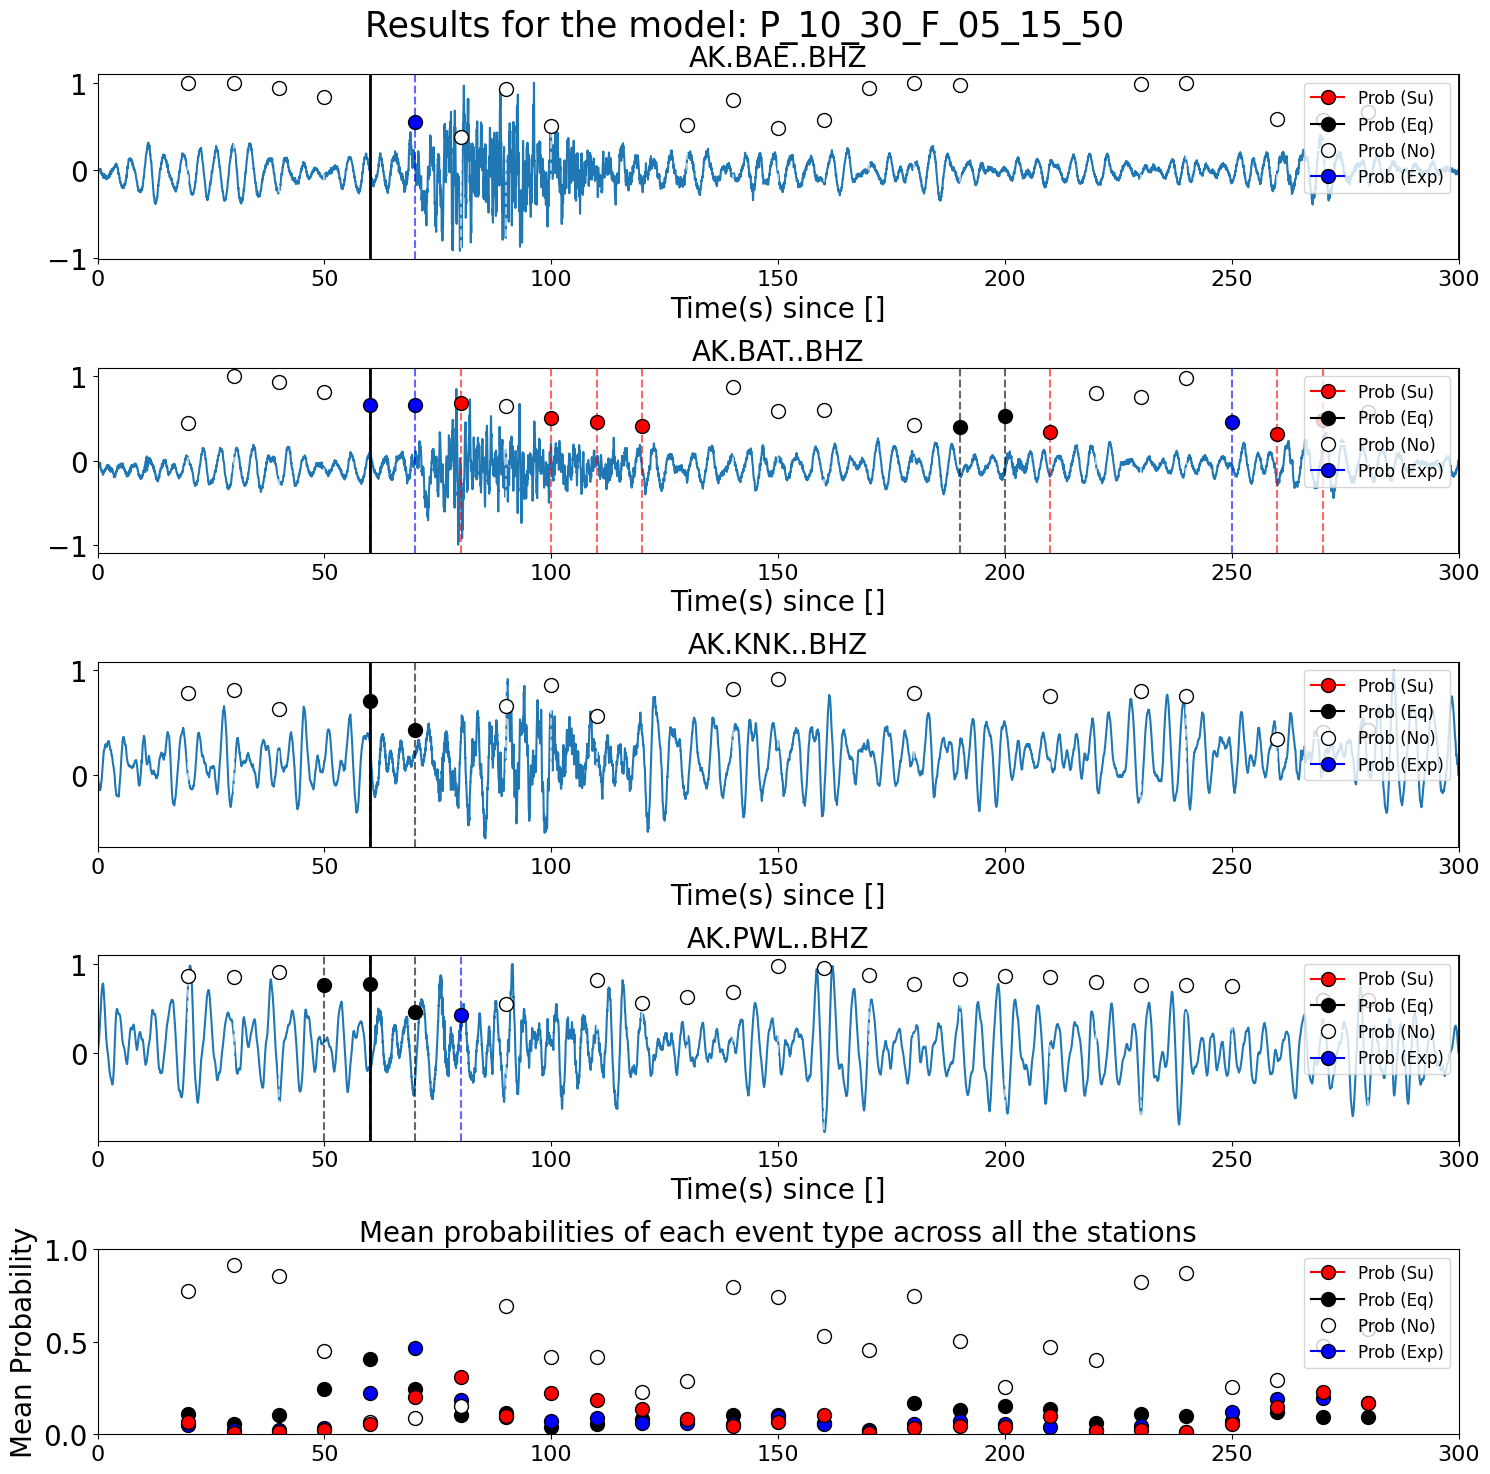

In [11]:
# startttime of trace (UTCDateTime)
starttime = obspy.UTCDateTime(2021, 8, 9, 7, 45, 40) - 60
# duration
dur = 300
# stations ID
stations_id = [ 'AK.BAE', 'AK.BAT', 'AK.KNK', 'AK.PWL']
location = '*'




filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)



100%|██████████| 61/61 [00:00<00:00, 545527.81it/s]

100%|██████████| 61/61 [00:00<00:00, 673296.17it/s]

1 Trace(s) in Stream:
CC.SEP..BHZ | 2024-05-09T03:32:04.000000Z - 2024-05-09T03:42:04.000000Z | 50.0 Hz, 30001 samples



100%|██████████| 61/61 [00:00<00:00, 720711.39it/s]

100%|██████████| 61/61 [00:00<00:00, 897728.22it/s]

1 Trace(s) in Stream:
CC.REM..BHZ | 2024-05-09T03:32:04.000000Z - 2024-05-09T03:42:04.000000Z | 50.0 Hz, 30001 samples



100%|██████████| 61/61 [00:00<00:00, 654354.33it/s]

100%|██████████| 61/61 [00:00<00:00, 841620.21it/s]

1 Trace(s) in Stream:
UW.HSR..HHZ | 2024-05-09T03:32:04.000000Z - 2024-05-09T03:42:04.000000Z | 100.0 Hz, 60001 samples



100%|██████████| 61/61 [00:00<00:00, 708732.81it/s]

100%|██████████| 61/61 [00:00<00:00, 836119.42it/s]

1 Trace(s) in Stream:
CC.VALT..BHZ | 2024-05-09T03:32:04.000000Z - 2024-05-09T03:42:04.000000Z | 50.0 Hz, 30001 samples



100%|██████████| 4/4 [00:21<00:00,  5.50s/it]


57


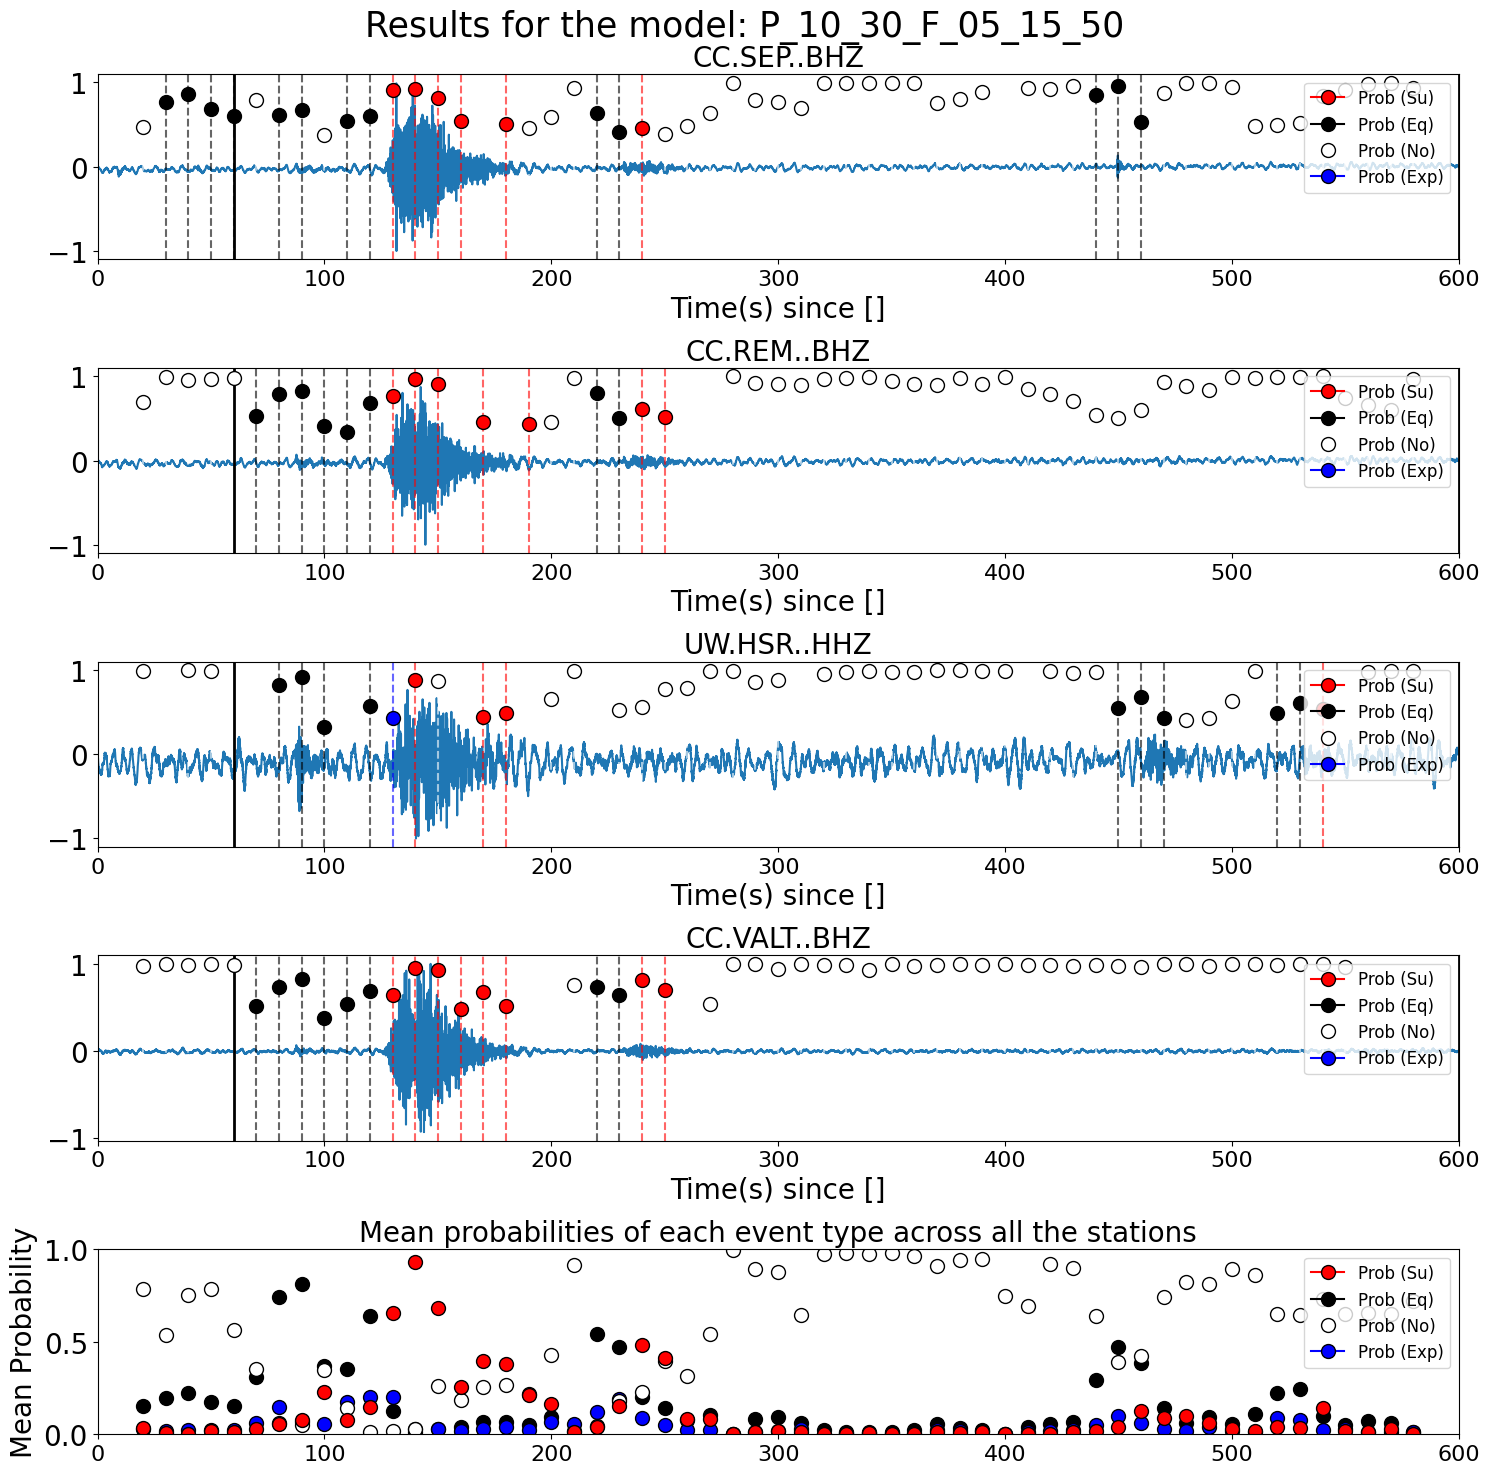

In [12]:
# startttime of trace
starttime = obspy.UTCDateTime(2024, 5, 9, 3, 33, 34) - 90
# duration
dur = 600
# stations ID
stations_id = ['CC.SEP', 'CC.REM', 'UW.HSR', 'CC.VALT']
location = '*'




filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)



## An Earthquake

 20%|██        | 1/5 [00:01<00:05,  1.35s/it]

0 Trace(s) in Stream:



 40%|████      | 2/5 [00:02<00:03,  1.26s/it]

0 Trace(s) in Stream:




100%|██████████| 41/41 [00:00<00:00, 540775.04it/s]

100%|██████████| 41/41 [00:00<00:00, 704780.59it/s]

1 Trace(s) in Stream:
UW.COWS..HHZ | 2024-06-16T06:59:33.000000Z - 2024-06-16T07:06:13.000000Z | 100.0 Hz, 40001 samples



100%|██████████| 40/40 [00:00<00:00, 566797.84it/s]

100%|██████████| 40/40 [00:00<00:00, 696150.04it/s]

1 Trace(s) in Stream:
UW.SP2..HHZ | 2024-06-16T06:59:33.009999Z - 2024-06-16T07:06:12.999999Z | 100.0 Hz, 40000 samples



100%|██████████| 41/41 [00:00<00:00, 530760.69it/s]

100%|██████████| 41/41 [00:00<00:00, 693413.16it/s]

1 Trace(s) in Stream:
UW.BHW..HHZ | 2024-06-16T06:59:33.000000Z - 2024-06-16T07:06:13.000000Z | 100.0 Hz, 40001 samples



100%|██████████| 5/5 [00:14<00:00,  2.94s/it]


37


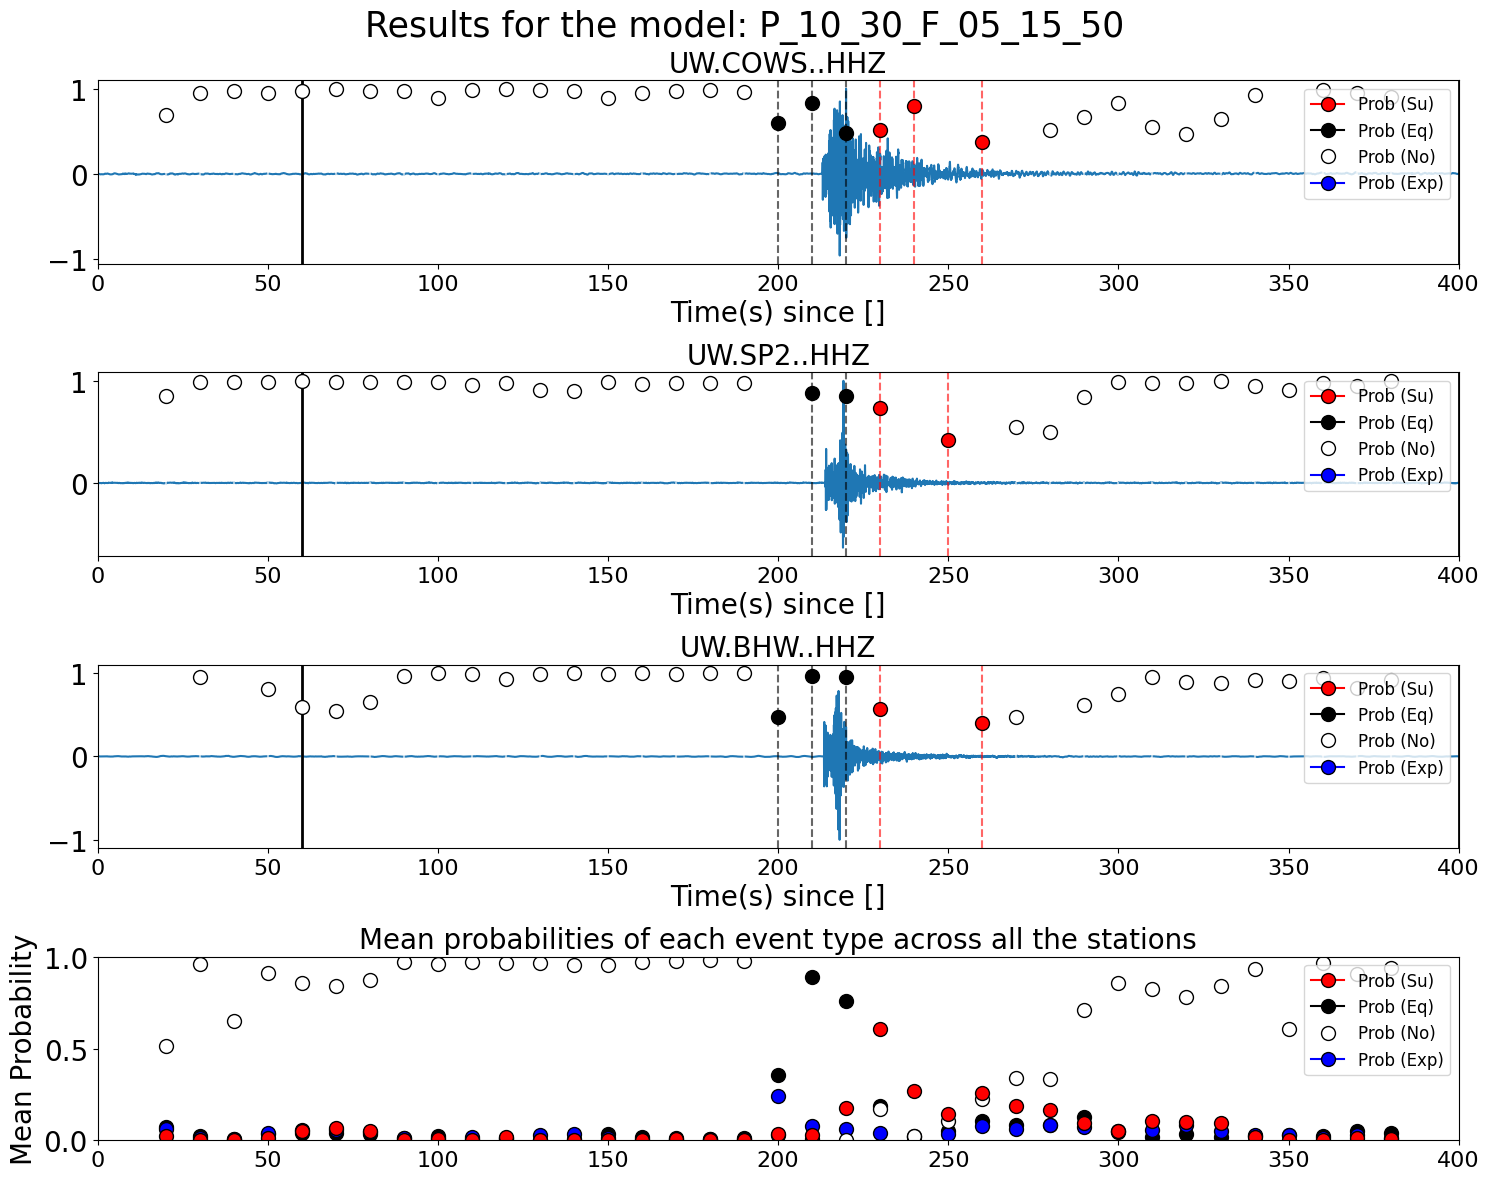

In [13]:
# startttime of trace
starttime = obspy.UTCDateTime(2024,6,16,7,3,3) - 210

# duration
dur = 400

# stations ID
stations_id = ['UW.MARY',  'UW.MS99', 'UW.COWS', 'UW.SP2', 'UW.BHW']
location = '*'




filename = 'P_10_30_F_05_15_50'
highcut, win, new_sr = infer_info(filename)
original_sr = 100
lowcut = 0.5
num_corners = 4
samp_freq = 100

result_stns, index_stns, prob_stns, st_overall, st_overall_data, st_overall_times  = event_detection(starttime = starttime, stations_id = stations_id, dur = dur, stride = stride, new_sr = new_sr, 
                           original_sr = original_sr, low = lowcut, high = highcut, num_corners = num_corners, location = location, samp_freq = samp_freq, win = win, filename = filename, top_20 = top_20)




plot_detection_results(st_overall_data = st_overall_data, st_overall_times = st_overall_times, 
                       st_overall = st_overall, result_stns = result_stns, index_stns = index_stns, 
                       prob_stns = prob_stns, xlim = [0,dur], ev_markers = [before,dur], shift = stride, win = win, filename = filename)



## Deleting the large downloaded files 
so we can push to github repository.


In [14]:
# Get the current working directory
directory = os.getcwd()

# List the files in the directory
files = os.listdir(directory)

# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".joblib"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)
        
# Iterate over the files and delete CSV files
for file in files:
    if file.endswith(".csv"):
        file_path = os.path.join(directory, file)
        os.remove(file_path)